In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split
from sklearn.utils import resample

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# from google.colab import drive
# drive.mount('/content/drive')

# folder_path = '/content/drive/My Drive/Colab Notebooks/Machine Learning/projet2'

# Partie 1 - Machine learning classique

## Analyse des données

,Classe,SousClasse,GaborFeature0,GaborFeature1,GaborFeature2,GaborFeature3,GaborFeature4,GaborFeature5,GaborFeature6,GaborFeature7,...,GaborFeature17,GaborFeature18,GaborFeature19,GaborFeature20,GaborFeature21,GaborFeature22,GaborFeature23,Y_Feature,Cr_Feature,Cb_Feature
Numero,,,,,,,,,,,,,,,,,,,,,
1927,NATUREL,OPEN_COUNTRY,-0.534358,-0.525756,-0.569507,-0.526244,-0.758949,-0.777145,-0.655355,-0.194852,...,-0.245392,-0.350766,-0.139132,-0.638998,-0.593121,-0.531703,-0.231393,0.468970,0.848787,-2.490682
2076,ARTIFICIEL,RUE,0.111617,0.225386,0.719857,0.509317,1.327478,1.404515,0.396153,-0.095375,...,1.359529,0.792866,0.670435,0.818410,0.837560,0.535152,0.098582,0.135082,0.527263,-0.477937
1012,ARTIFICIEL,VILLE,-0.175443,-0.052435,0.877849,0.067135,0.396117,0.129128,1.834266,0.200591,...,0.728218,0.369247,0.001506,-0.286736,0.401835,0.802573,0.158772,-0.822426,0.127975,0.144827
2069,ARTIFICIEL,RUE,-0.239083,0.130569,0.201182,0.221323,0.263732,0.827890,1.515108,0.667714,...,2.133495,0.701045,0.373932,0.242101,0.413113,0.288646,0.403911,0.764572,-0.459236,0.106642
951,ARTIFICIEL,VILLE,0.670929,0.289145,0.246102,-0.200038,0.892492,-0.377802,-0.475454,-0.444830,...,-0.527731,-0.631941,-0.305346,0.424133,-0.365025,-0.489855,-0.428821,1.020113,-1.272951,1.255535


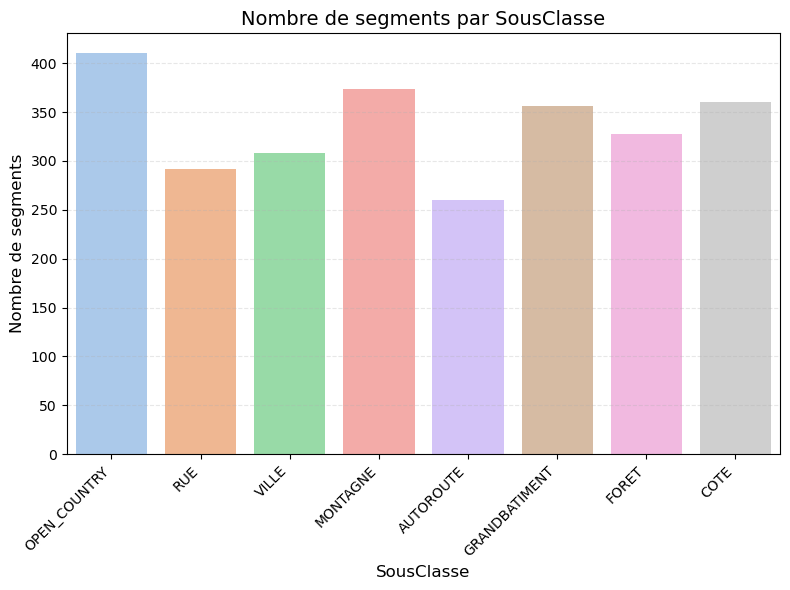

In [9]:
# Df avec les classes
X = [] 

# Df sans les classes
Xnum = []

X = pd.read_csv("database.csv", header=0, index_col=0)
# X = pd.read_csv(folder_path + "/database.csv", header=0, index_col=0)
Xnum = X.iloc[:,2:]

# Nouveau df X2 avec des numéros atribués pour les sousclasses
X2 = X.copy()
mapping = dict(zip(X["SousClasse"].unique(), range(8)))
X2['SousClasse'] = X2['SousClasse'].map(mapping)

display(X.head())
# print(X["SousClasse"].unique()) 

plt.figure(figsize=(8,6))

sns.countplot(x='SousClasse', hue='SousClasse', data=X, palette='pastel', legend=False)

plt.title('Nombre de segments par SousClasse', fontsize=14)
plt.xlabel('SousClasse', fontsize=12)
plt.ylabel('Nombre de segments', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

PCA variance ratio: [0.34702301 0.10743652 0.09349413]
LDA explained variance ratio: [0.46567982 0.26652918 0.12897374]


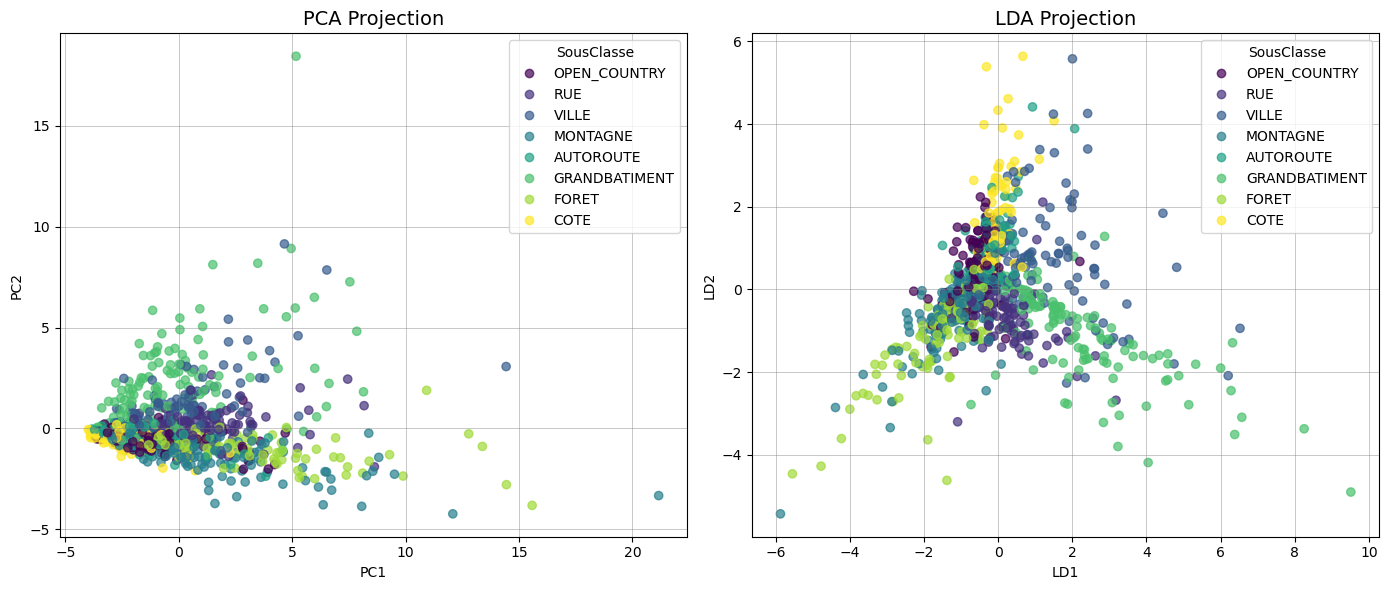

In [ ]:
Xtrain, Xtest, ytrain, ytest = train_test_split(Xnum, X2['SousClasse'], test_size=0.33, random_state=9)

pca = PCA(n_components=3)
Xpca = pca.fit_transform(Xtest)
print("PCA variance ratio:", pca.explained_variance_ratio_)

lda = LinearDiscriminantAnalysis(n_components=3)
Xlda = lda.fit_transform(Xtest, ytest)
print("LDA explained variance ratio:", lda.explained_variance_ratio_)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

ax = axes[0]
scatter_pca = ax.scatter(Xpca[:,0], Xpca[:,1], c=ytest, alpha=0.7)
ax.set_title("PCA Projection", fontsize=14)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.grid(True, linewidth=0.5, color='gray', alpha=0.6)

legend_labels = X["SousClasse"].unique().tolist()
ax.legend(handles=scatter_pca.legend_elements()[0],
          labels=legend_labels,
          title="SousClasse")

ax = axes[1]
scatter_lda = ax.scatter(Xlda[:,0], Xlda[:,1], c=ytest, alpha=0.7)
ax.set_title("LDA Projection", fontsize=14)
ax.set_xlabel("LD1")
ax.set_ylabel("LD2")
ax.grid(True, linewidth=0.5, color='gray', alpha=0.6)

ax.legend(handles=scatter_lda.legend_elements()[0],
          labels=legend_labels,
          title="SousClasse")

plt.tight_layout()
plt.show()

## MLP et SVM

### Construction des classifieurs

In [10]:
# Définition des classifieurs
models = {
    "SVM": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC())
    ]),
    
    "MLP": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", MLPClassifier(max_iter=2000, random_state=42, early_stopping=True, n_iter_no_change=20))
    ]),
}

# Paramètres à optimiser
param_grid_mlp = {
    'clf__hidden_layer_sizes': [(12,), (14,), (16,), (17,), (18,), (19,), (20,)],
    'clf__activation': ['relu', 'tanh', 'logistic'],
    'clf__alpha': [0.0001, 0.001, 0.01]
}

param_grid_svm = {
    'clf__kernel': ['rbf', 'linear'],
    'clf__C': [0.1, 1, 10],
    'clf__gamma': ['scale', 'auto', 0.01, 0.1, 1],
    'clf__decision_function_shape': ['ovr', 'ovo']
}

# Validation croisée
num_cv = 5

grid_mlp = GridSearchCV(models["MLP"], param_grid_mlp, cv=num_cv, scoring='balanced_accuracy', n_jobs=-1) # n_jobs peut ralentir l'ordi
grid_mlp.fit(Xtrain, ytrain)

grid_svm = GridSearchCV(models["SVM"], param_grid_svm, cv=num_cv, scoring='balanced_accuracy')
grid_svm.fit(Xtrain, ytrain)

print("Meilleurs paramètres MLP:", grid_mlp.best_params_)
print(f"Balanced accuracy MLP: {grid_mlp.best_score_:.3f}")

print("\nMeilleurs paramètres SVM:", grid_svm.best_params_)
print(f"Balanced accuracy SVM: {grid_svm.best_score_:.3f}")

mlp_best_model = grid_mlp.best_estimator_
svm_best_model = grid_svm.best_estimator_

y_pred_mlp = mlp_best_model.predict(Xtest)
y_pred_svm = svm_best_model.predict(Xtest)

Meilleurs paramètres MLP: {'clf__activation': 'tanh', 'clf__alpha': 0.01, 'clf__hidden_layer_sizes': (17,)}
Balanced accuracy MLP: 0.655

Meilleurs paramètres SVM: {'clf__C': 10, 'clf__decision_function_shape': 'ovr', 'clf__gamma': 0.01, 'clf__kernel': 'rbf'}
Balanced accuracy SVM: 0.687


### Comparaison des performances

MLP Balanced Accuracy: 0.5883, IC 95%: [0.5586, 0.6184]
SVM Balanced Accuracy: 0.7185, IC 95%: [0.6884, 0.7467]


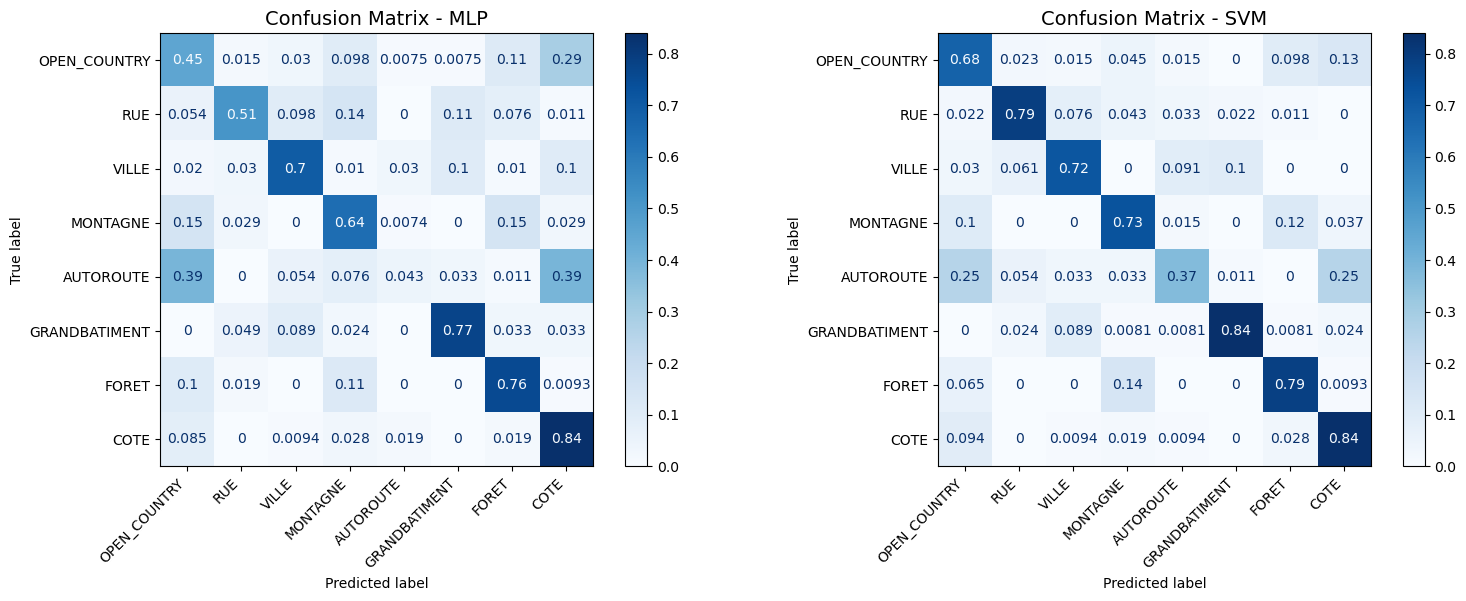

MLP:
               precision    recall  f1-score   support

           0       0.42      0.45      0.43       133
           1       0.73      0.51      0.60        92
           2       0.70      0.70      0.70        99
           3       0.63      0.64      0.63       136
           4       0.36      0.04      0.08        92
           5       0.80      0.77      0.79       123
           6       0.62      0.76      0.68       107
           7       0.49      0.84      0.62       106

    accuracy                           0.60       888
   macro avg       0.59      0.59      0.57       888
weighted avg       0.59      0.60      0.57       888

SVM:
               precision    recall  f1-score   support

           0       0.60      0.68      0.64       133
           1       0.81      0.79      0.80        92
           2       0.75      0.72      0.73        99
           3       0.76      0.73      0.74       136
           4       0.65      0.37      0.47        92
           5

In [15]:
# def fait avec l'IA
def bootstrap_ci(y_true, y_pred, metric_func, n_bootstrap=1000, ci=95):
    scores = []
    n = len(y_true)
    
    for _ in range(n_bootstrap):
        idx = np.random.choice(n, n, replace=True)
        score = metric_func(y_true[idx], y_pred[idx])
        scores.append(score)
    
    lower = np.percentile(scores, (100-ci)/2)
    upper = np.percentile(scores, 100-(100-ci)/2)
    mean = np.mean(scores)
    
    return mean, lower, upper

# Balanced Accuracies
ytest_arr = np.array(ytest)
y_pred_mlp_arr = np.array(y_pred_mlp)
y_pred_svm_arr = np.array(y_pred_svm)

mean_mlp, lower_mlp, upper_mlp = bootstrap_ci(ytest_arr, y_pred_mlp_arr, balanced_accuracy_score)
print(f"MLP Balanced Accuracy: {mean_mlp:.4f}, IC 95%: [{lower_mlp:.4f}, {upper_mlp:.4f}]")

mean_svm, lower_svm, upper_svm = bootstrap_ci(ytest_arr, y_pred_svm_arr, balanced_accuracy_score)
print(f"SVM Balanced Accuracy: {mean_svm:.4f}, IC 95%: [{lower_svm:.4f}, {upper_svm:.4f}]")

# Matrices de confusion
labels = np.arange(8)
labels_names = ['OPEN_COUNTRY','RUE','VILLE','MONTAGNE','AUTOROUTE','GRANDBATIMENT','FORET','COTE']

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

cm_mlp = confusion_matrix(ytest, y_pred_mlp, labels=labels, normalize='true')
disp_mlp = ConfusionMatrixDisplay(confusion_matrix=cm_mlp, display_labels=labels_names)
disp_mlp.plot(cmap='Blues', colorbar=True, ax=axes[0])

axes[0].set_xticklabels(labels_names, rotation=45, ha='right')
axes[0].set_yticklabels(labels_names, rotation=0)
axes[0].set_title("Confusion Matrix - MLP", fontsize=14)

cm_svm = confusion_matrix(ytest, y_pred_svm, labels=labels, normalize='true')
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=labels_names)
disp_svm.plot(cmap='Blues', colorbar=True, ax=axes[1])

axes[1].set_xticklabels(labels_names, rotation=45, ha='right')
axes[1].set_yticklabels(labels_names, rotation=0)
axes[1].set_title("Confusion Matrix - SVM", fontsize=14)

plt.tight_layout()
plt.show()

# Rapport complet
print("MLP:\n", classification_report(ytest, y_pred_mlp))
print("SVM:\n", classification_report(ytest, y_pred_svm))

# Partie 2 - Deep Learning — CNN (Convolutional Neural Networks)

## L’apprentissage, validation et test